# RNA-Seq Analysis

I'd like to explore some different aspects of the expression profiles for 
the different samples. There are some additional samples besides those
used for the eQTL study because for some people we sequenced multiple clones
etc.

I'll generally be looking at the all of the data but I'll also look
at a subset of European individuals from different families to remove 
some of the genetic and ancestry signal. While it's true that some family
members are genetically unrelated, I will just take one person per family
to avoid similarities from shared familial environment.

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import svd
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

outdir = os.path.join(ciepy.root, 'output',
                      'rna_seq_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'rna_seq_analysis')
cpy.makedir(private_outdir)

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

ext_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211.tsv'), index_col=0,
                         low_memory=False)

tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv'), index_col=0,
                                 low_memory=False)
ext_tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'GSE73211_tpm.tsv'), index_col=0,
                        low_memory=False)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'star_logs.tsv')
star_logs = pd.read_table(fn, index_col=0)

In [4]:
meta = rna_meta.merge(subject_meta, left_on='subject_id', 
                      right_index=True, how='inner')

## STAR Logs

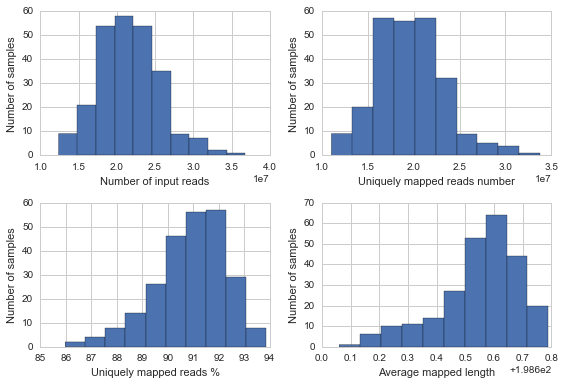

In [5]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
ax = axs[0]
k = 'Number of input reads'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[1]
k = 'Uniquely mapped reads number'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[2]
k = 'Uniquely mapped reads %'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[3]
k = 'Average mapped length'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
plt.tight_layout()

In [6]:
n = star_logs['Number of input reads'].mean()
print('Average of {:.2f} million read pairs per sample'.format(n / 10**6))

Average of 21.59 million read pairs per sample


In [10]:
star_logs['Uniquely mapped reads %'].min()

85.969999999999999

In [9]:
star_logs['Uniquely mapped reads %'].median()

91.02

In [11]:
wgs_meta.cell.value_counts()

Blood         255
Fibroblast     19
Name: cell, dtype: int64

## Expression Distribution

250    19020
0      15313
dtype: int64


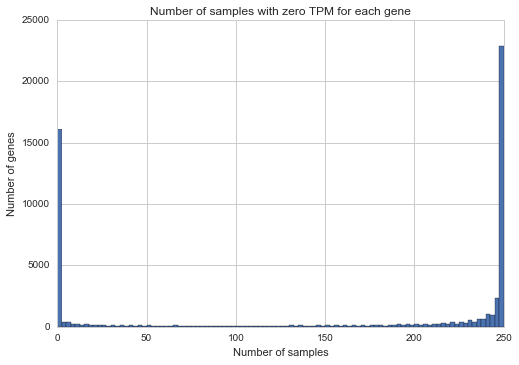

In [14]:
s = (tpm == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist(bins=100)
plt.title('Number of samples with zero TPM for each gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

We can see overal that there are a fair number of genes that are not expressed
in any samples.

0      13524
250      906
dtype: int64


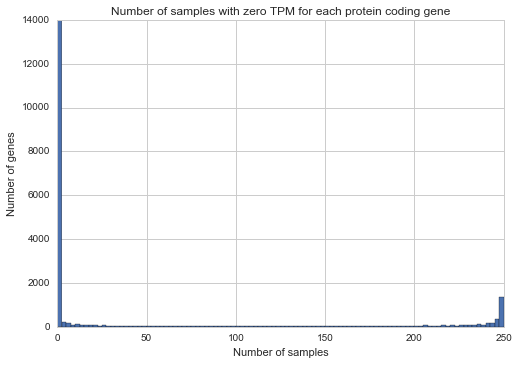

In [15]:
s = (tpm[gene_info.ix[tpm.index, 'gene_type'] == 'protein_coding'] == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist(bins=100)
plt.title('Number of samples with zero TPM for each protein coding gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

Protein coding genes are highly enriched for being expressed in all samples.

## Pluripotency gene expression

In [ ]:
plur_markers = ['POU5F1', 'SOX2', 'NANOG', 'ZFP42', 'LIN28A']
diff_markers = ['T', 'EOMES', 'SOX17', 'FOXA2', 'GATA4', 'HAND1', 
                'CDX2', 'PAX6', 'SOX1', 'EN1']
def get_gene_id(x):
    return gene_info[gene_info.gene_name == x].index[0]
plur_markers = pd.Series(plur_markers, index=[get_gene_id(x) for x in plur_markers])
diff_markers = pd.Series(diff_markers, index=[get_gene_id(x) for x in diff_markers])

url = 'http://www.nature.com/nbt/journal/v33/n11/extref/nbt.3387-S5.xlsx'
scorecard = pd.read_excel(url)
scorecard = scorecard.drop(scorecard.columns[2:], axis=1)
scorecard = scorecard[scorecard.gene.apply(lambda x: x in gene_info.gene_name.values)]
scorecard.index = [get_gene_id(x) for x in scorecard.gene]
scorecard = scorecard[scorecard['class'].apply(lambda x: x in ['Mesoderm', 'Pluri'])]

tpm_all = pd.concat([tpm, ext_tpm], axis=1)

In [ ]:
tdf = np.log10(tpm_all.ix[scorecard.index].T + 1)
tdf = tdf - tdf.mean()
tdf = tdf / tdf.std()

In [ ]:
cs = pd.Series(dict(zip(list(set(ext_meta.cell_type)), sns.color_palette('colorblind')[3:6])))
rc = ([sns.color_palette('colorblind')[2]] * tpm.shape[1]) + list(cs[ext_meta.cell_type])
cs = pd.Series(dict(zip(list(set(scorecard['class'])), sns.color_palette("Set2", 7))))
cc = cs[scorecard['class']]

sns.clustermap(tdf, xticklabels=[], yticklabels=[], col_colors=cc, row_colors=rc);#, col_cluster=False);

## All samples

### Variable Genes

I'm interested in what genes are variable among all samples

In [16]:
# Filter for robustly expressed genes and take log.
tpm_f = tpm[(tpm == 0).sum(axis=1) == 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

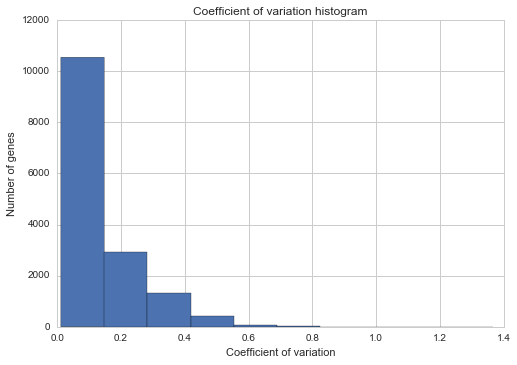

In [17]:
cov = log_tpm.std(axis=1) / log_tpm.mean(axis=1)
cov.sort_values(ascending=False, inplace=True)
cov.hist()
plt.title('Coefficient of variation histogram')
plt.xlabel('Coefficient of variation')
plt.ylabel('Number of genes');

### Clustering

## SVD

In [18]:
res = cpb.analysis.SVD(log_tpm, scale_variance=True)

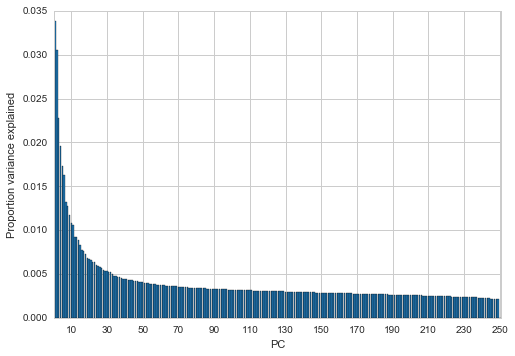

In [19]:
res.plot_variance_explained(xtick_start=10, xtick_spacing=20, cumulative=False)

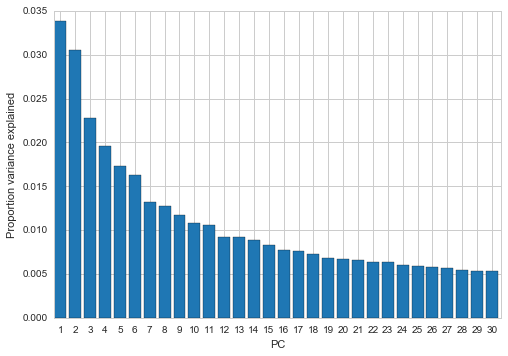

In [20]:
res.plot_variance_explained(num_pc=30)

In [21]:
pc_anova = res.pc_anova(meta[['sex', 'ethnicity_group', 'sequence_id']])
pc_anova.pvalue

,PC1,PC2,PC3,PC4,PC5
sex,0.358010,1.514248e-01,8.814301e-01,0.019714,0.884173
ethnicity_group,0.174594,9.031497e-01,2.686777e-01,0.358136,0.335773
sequence_id,0.027947,4.124048e-26,3.291938e-07,0.000669,0.989441


/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/axes/_axes.py:492: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


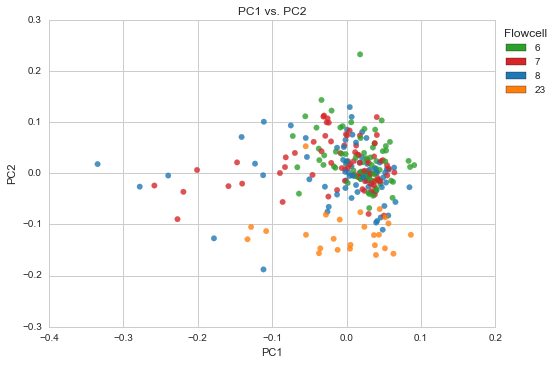

In [22]:
fig, ax = res.plot_pc_scatter(
    'PC1', 'PC2',
    color=meta.ix[res.v.index, 'sequence_id'],
    color_name='Flowcell')

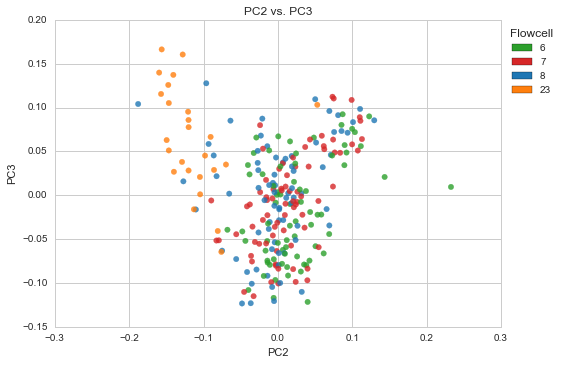

In [23]:
fig, ax = res.plot_pc_scatter(
    'PC2', 'PC3',
    color=meta.ix[res.v.index, 'sequence_id'],
    color_name='Flowcell')

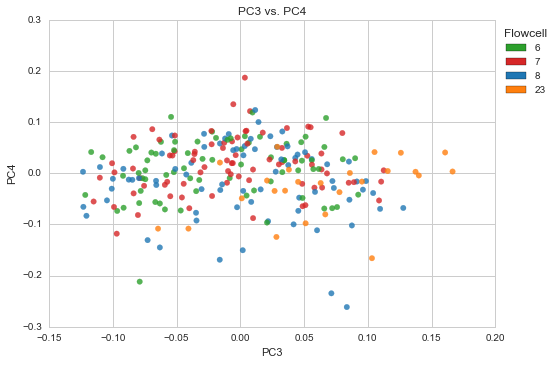

In [24]:
fig, ax = res.plot_pc_scatter(
    'PC3', 'PC4',
    color=meta.ix[res.v.index, 'sequence_id'],
    color_name='Flowcell')

The ANOVA and PC plots show that the different batches on the flowcells
definitely have an effect on the expression values. The flowcell with ID
23 was done a month or so after the other three flowcells (23 had the
samples that failed QC from the first three flowcells) so it's not surprising
that it's more different. 

## Subset of Samples

In [20]:
a = meta.dropna(subset=['family_id']).drop_duplicates(subset=['family_id'])
b = meta[meta.family_id.isnull()]
euro_no_fam = pd.concat([a, b])

In [21]:
# Filter for robustly expressed genes and take log.
subset_tpm_f = tpm.ix[(tpm == 0).sum(axis=1) == 0, euro_no_fam.index]
subset_log_tpm = np.log10(subset_tpm_f + 1)
# Mean center.
subset_log_tpm_c = (subset_log_tpm.T - subset_log_tpm.mean(axis=1)).T
# Variance normalize.
subset_log_tpm_n = (subset_log_tpm_c.T / subset_log_tpm_c.std(axis=1)).T

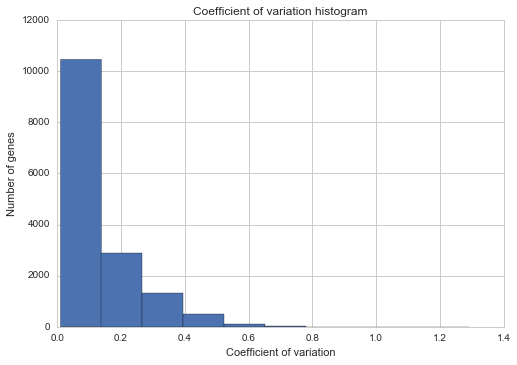

In [22]:
subset_cov = subset_log_tpm.std(axis=1) / subset_log_tpm.mean(axis=1)
subset_cov.sort_values(ascending=False, inplace=True)
subset_cov.hist()
plt.title('Coefficient of variation histogram')
plt.xlabel('Coefficient of variation')
plt.ylabel('Number of genes');

In [23]:
subset_svd = cpb.analysis.SVD(subset_log_tpm, scale_variance=True)

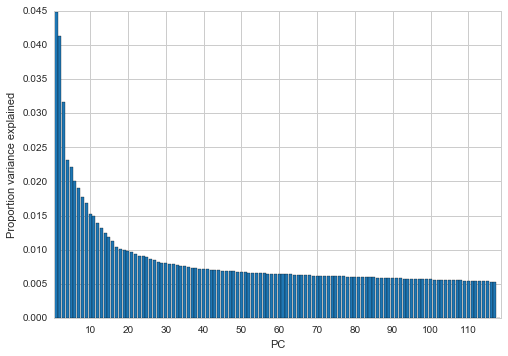

In [24]:
subset_svd.plot_variance_explained(xtick_start=10, xtick_spacing=10, cumulative=False)

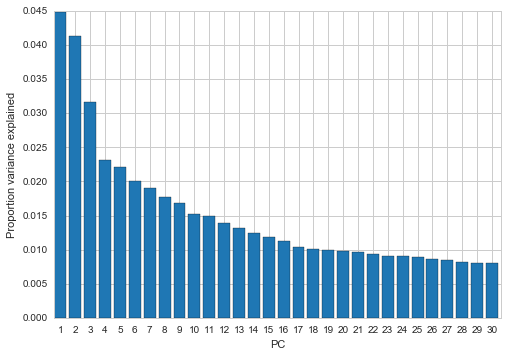

In [25]:
subset_svd.plot_variance_explained(num_pc=30)

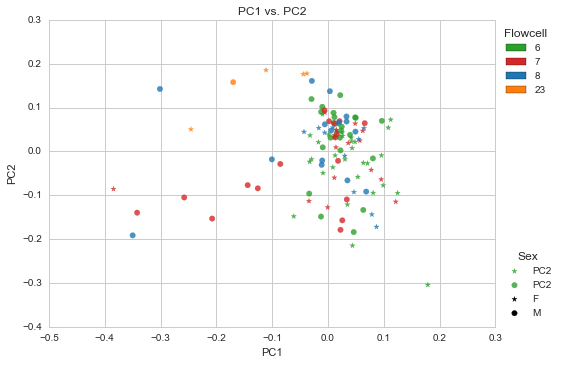

In [26]:
fig, ax = subset_svd.plot_pc_scatter(
    'PC1', 'PC2',
    color=meta.ix[subset_svd.v.index, 'sequence_id'],
    marker=meta.ix[subset_svd.v.index, 'sex'],
    color_name='Flowcell',
    marker_name='Sex')

In [27]:
subset_svd_500 = cpb.analysis.SVD(subset_log_tpm_n.ix[subset_cov.head(500).index])

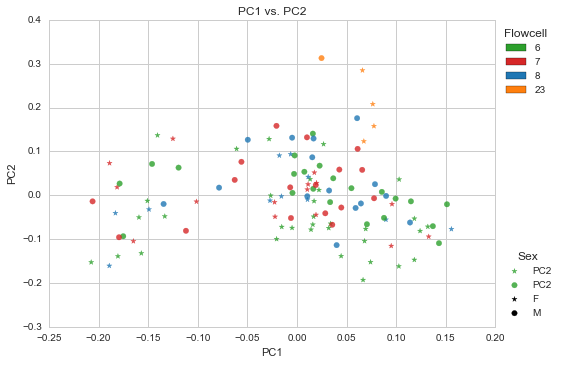

In [28]:
fig, ax = subset_svd_500.plot_pc_scatter(
    'PC1', 'PC2',
    color=meta.ix[subset_svd.v.index, 'sequence_id'],
    marker=meta.ix[subset_svd.v.index, 'sex'],
    color_name='Flowcell',
    marker_name='Sex')

TODO: Working here. Update stuff below.

In [ ]:
t = subset_log_tpm_n.ix[subset_cov.head(500).index]
ct = t.corr(method='spearman')
cg = sns.clustermap(
    ct, xticklabels=False, yticklabels=False,
    row_colors=color_meta.ix[ct.index, ['sex']].T.values,
    col_colors=color_meta.ix[ct.index, ['sequence_id']].T.values)

In [17]:
tdf = subset_log_tpm_n.ix[subset_cov.head(500).index]
fn = os.path.join(outdir, 'subset_sparse_pca.tsv')
p = os.path.join(outdir, 'subset_sparse_pca.pickle')
if not os.path.exists(fn):
    from sklearn import decomposition
    sparse_pca = decomposition.SparsePCA(n_components=5, n_jobs=30)
    sparse_pca.fit(tdf.T)
    
    ind = ['PC{}'.format(x) for x in 
            range(1, sparse_pca.components_.shape[0] + 1)]
    sparse_components = pd.DataFrame(sparse_pca.components_, 
                                      columns=tdf.index,
                                      index=ind).T
    sparse_components.to_csv(fn, sep='\t')
    cPickle.dump(sparse_pca, open(p, 'wb'))
else:
    sparse_componenets = pd.read_table(fn, index_col=0, header=0)
    sparse_pca = cPickle.load(open(p, 'rb'))

In [ ]:
#plt.scatter(subset_svd_500.u['PC1'], sparse_pca.components_[0], lw=0, alpha=0.8)
ax = sns.jointplot(subset_svd_500.u['PC1'], sparse_pca.components_[0],
                   stat_func=None, alpha=0.25)
plt.xlabel('PCA loading')
plt.ylabel('Sparse PCA loading')
ax.set_axis_labels(xlabel='Distance in kb',
                   ylabel='$-\log_{10}$ $p$-value')
plt.tight_layout()
#plt.title('PCA vs. sparse PCA first eigenvector');

In [34]:
sparse_pca.components_[0].max()

6.4246762602555894

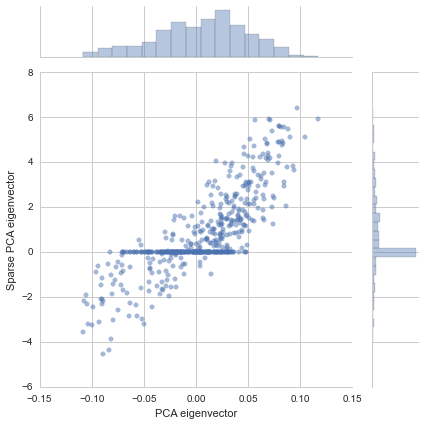

In [41]:
ax = sns.jointplot(x=subset_svd_500.u['PC1'].values, y=sparse_pca.components_[0],
                   stat_func=None, alpha=0.5)
ax.set_axis_labels(xlabel='PCA eigenvector',
                   ylabel='Sparse PCA eigenvector')
plt.tight_layout()

In [22]:
genes = [x.split('.')[0] for x in subset_cov.index]
sig = np.array([False] * len(genes))
sig[0:500] = True
subset_var_go_results = cpb.analysis.goseq_gene_enrichment(genes, sig)

Loading hg19 length data...
Fetching GO annotations...
For 2296 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


In [19]:
genes = [x.split('.')[0] for x in subset_cov.index]
sig = pd.Series(np.array([False] * len(genes)), index=subset_cov.index)
se = pd.Series(sparse_pca.components_[0], index=tdf.index)
sig[se[se != 0].index] = True
spc1_var_go_results = cpb.analysis.goseq_gene_enrichment(genes, sig.values)

Loading hg19 length data...
Fetching GO annotations...

For 2296 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


In [21]:
spc1_var_go_results.head()

,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_pvalue_bh,under_represented_pvalue_bh
category,,,,,,,,
GO:0031224,3.020596e-11,1,114,3328,intrinsic component of membrane,CC,5.220496e-07,1
GO:0016021,2.353574e-10,1,110,3264,integral component of membrane,CC,1.213162e-06,1
GO:0071944,2.633799e-10,1,105,2872,cell periphery,CC,1.213162e-06,1
GO:0005886,2.807758e-10,1,103,2794,plasma membrane,CC,1.213162e-06,1
GO:0005887,6.171066e-10,1,44,754,integral component of plasma membrane,CC,2.133091e-06,1


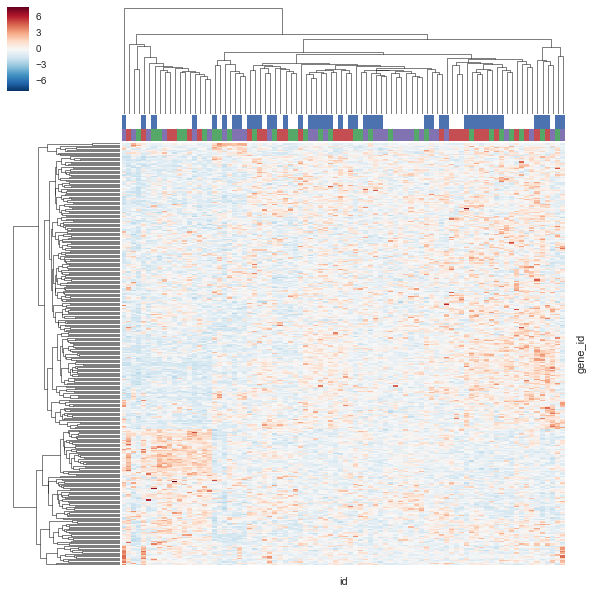

In [52]:
se = pd.Series(sparse_pca.components_[0], index=tdf.index)
t = subset_log_tpm_n.ix[se[se != 0].index]
cg = sns.clustermap(
    t, xticklabels=False, yticklabels=False,
    col_colors=color_meta.ix[ct.index, ['sex', 'sequence_id']].T.values)

In [ ]:
3 + 3

In [ ]:
3 + 

## Correlation with Covariates

In [28]:
def transform_standard_normal(df):
    gc_ranks = df.rank(axis=1)
    gc_ranks = gc_ranks / (gc_ranks.shape[1] + 1)
    std_norm = stats.norm.ppf(gc_ranks)
    std_norm = pd.DataFrame(std_norm, index=gc_ranks.index, 
                            columns=gc_ranks.columns)
    return std_norm

In [29]:
std_norm_tpm = transform_standard_normal(log_tpm)

In [27]:
tdf = subject_meta[subject_meta.estimated_ethnicity == 'EUR']
a = tdf[tdf.family_id.isnull()]
b = tdf.dropna(subset=['family_id'])
b = b.drop_duplicates(subset=['family_id'])
tdf = pd.concat([a, b])
print('Number to use for covariate correlation: {}'.format(tdf.shape[0]))

Number to use for covariate correlation: 87


In [86]:
lm_cov = copy.deepcopy(rna_meta)
lm_cov = lm_cov.merge(tdf, left_on='subject_id', right_index=True)
lm_cov = lm_cov[['passage', 'sex', 'age', 'sequence_id']]
lm_cov['sequence_id'] = lm_cov.sequence_id.astype(str)
#lm_cov = pd.get_dummies(data=lm_cov, columns=['sequence_id']).drop('sequence_id_6', axis=1)
lm_data = lm_cov.join(std_norm_tpm.T)
lm_data.columns = [x.replace('.', '_') for x in lm_data.columns]

In [89]:
pvalues = pd.DataFrame(
    [results[k].pvalues for k in results.keys()],
    index=[x.replace('_', '.') for x in results.keys()])

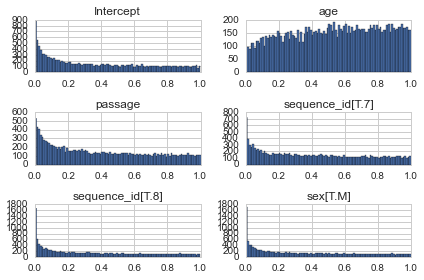

In [107]:
pvalues.hist(bins=100)
plt.tight_layout();

In [109]:
%%R

library(qvalue)

In [127]:
pvals = pvalues['sex[T.M]']

In [128]:
%%R -i pvals -o qvalues,pi0,lfdr,sig

qobj = qvalue(p=pvals, fdr.level=0.05)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr
sig <- qobj$significant

summary(qobj)


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.6216436	

Cumulative number of significant calls:

        <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value    368    698  1711   2509  3411 4674 15251
q-value    197    299   599   1033  1563 2601 15251



In [129]:
qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                          index=['pvalue', 'qvalue', 'sig'],
                          columns=pvals.index).T
qvalue_res = qvalue_res.sort(['qvalue'])

In [134]:
gene_info.ix[qvalue_res[qvalue_res.sig].index]['chrom'].value_counts()

chrX     259
chr1     147
chr19    104
chr11     86
chr2      85
chr17     76
chr12     74
chr16     67
chr6      66
chr5      65
chr7      65
chr3      64
chr4      52
chr10     47
chr8      45
chr15     43
chr14     40
chr9      40
chr22     40
chr20     37
chr18     24
chr13     22
chr21     14
chrY       1
dtype: int64

In [ ]:
res = cpb.analysis.SVD(log_tpm, scale_variance=True)